# Project 2 - Housing Price Prediction

## Import Libraries and Load Data

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

#pd.set_option('display.max_rows', 500)

In [2]:
### Data manipulations have to be much more organised and much more verbose.
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')
df_sample = pd.read_csv('./datasets/sample_sub_reg.csv')

In [3]:
df_train.shape

(2051, 81)

In [97]:
df_test.shape

(879, 73)

In [4]:
df_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

In [6]:
df_train.isnull().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    330
               ... 
Misc Val          0
Mo Sold           0
Yr Sold           0
Sale Type         0
SalePrice         0
Length: 81, dtype: int64

## Cleaning

### Formating column heads to be lowercase and no whitespaces

In [7]:
df_train.columns = map(str.lower, df_train.columns) ### Good

In [8]:
df_train.columns = [i.replace(" ","_") for i in list(df_train.columns)]

### Drop irrelevant features

In [9]:
df_train = df_train.drop(['id', 'pid', 'misc_feature'], axis = 1)

### Fill NaN

Fill relevant cont null values with 0:
'lot_frontage', 'mas_vnr_area', 'garage_cars', 'garage_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf'

In [10]:
### I want to see scatter plots of the numerical variables, bar plots of the categorical variables before and (prefereably)
### after we start shooting them 

fill_con_cols = ['lot_frontage', 'mas_vnr_area', 'garage_cars', 'garage_area', 'bsmtfin_sf_1',
            'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf']
df_train[fill_con_cols] = df_train[fill_con_cols].fillna(0)

Fill relavant cat null values with none:
'garage_qual', 'garage_cond', 'garagetype', 'garagefinish', 'fireplacequ', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'alley', 'fence', 'pool_qc', 'mas_vnr_type'

In [11]:
fill_cat_cols = ['garage_qual', 'garage_cond', 'garage_type', 'garage_finish', 'fireplace_qu',
                 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2',
                 'alley', 'fence', 'pool_qc', 'mas_vnr_type']
df_train[fill_cat_cols] = df_train[fill_cat_cols].fillna('none')

### Drop NaN

Drop remaining null values:
'garage_yr_blt', 'mas_vnr_type', 'bsmt_full_bath', 'bsmt_half_bath'

In [12]:
#df_train = df_train.dropna().reset_index().drop('index', axis = 1)

In [13]:
df_train = df_train.drop(['garage_yr_blt', 'mas_vnr_type', 'bsmt_full_bath', 'bsmt_half_bath'], axis = 1)
### Some of these are decent predictors, and should not be dropped. Especially not before the data is visualised.

In [14]:
df_train.shape

(2051, 74)

In [15]:
df_train

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,60,RL,0.0,13517,Pave,none,IR1,Lvl,AllPub,CulDSac,...,0,0,0,none,none,0,3,2010,WD,130500
1,60,RL,43.0,11492,Pave,none,IR1,Lvl,AllPub,CulDSac,...,0,0,0,none,none,0,4,2009,WD,220000
2,20,RL,68.0,7922,Pave,none,Reg,Lvl,AllPub,Inside,...,0,0,0,none,none,0,1,2010,WD,109000
3,60,RL,73.0,9802,Pave,none,Reg,Lvl,AllPub,Inside,...,0,0,0,none,none,0,4,2010,WD,174000
4,50,RL,82.0,14235,Pave,none,IR1,Lvl,AllPub,Inside,...,0,0,0,none,none,0,3,2010,WD,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,20,RL,79.0,11449,Pave,none,IR1,HLS,AllPub,Inside,...,0,0,0,none,none,0,1,2008,WD,298751
2047,30,RL,0.0,12342,Pave,none,IR1,Lvl,AllPub,Inside,...,0,0,0,none,none,0,3,2009,WD,82500
2048,50,RL,57.0,7558,Pave,none,Reg,Bnk,AllPub,Inside,...,0,0,0,none,none,0,3,2009,WD,177000
2049,20,RL,80.0,10400,Pave,none,Reg,Lvl,AllPub,Corner,...,0,0,0,none,none,0,11,2009,WD,144000


## Dummying categorical columns

In [16]:
#ms_zoning = pd.get_dummies(df_train.ms_zoning)
#street = pd.get_dummies(df_train.street)

In [17]:
def dummy_conv(data):
    names=data.select_dtypes(exclude=['number']).columns
    return pd.get_dummies(data[names], drop_first=True)

In [18]:
df_train_cat = dummy_conv(df_train)

In [19]:
df_train_cat.shape

(2051, 217)

In [20]:
df_train.select_dtypes(exclude=['number']).columns

Index(['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour',
       'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
       'exterior_1st', 'exterior_2nd', 'exter_qual', 'exter_cond',
       'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc',
       'central_air', 'electrical', 'kitchen_qual', 'functional',
       'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual',
       'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'sale_type'],
      dtype='object')

In [21]:
df_train_cont = df_train.drop(['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour',
                               'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1',
                               'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
                               'exterior_1st', 'exterior_2nd', 'exter_qual',
                               'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
                               'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc',
                               'central_air', 'electrical', 'kitchen_qual', 'functional',
                               'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual',
                               'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'sale_type'], axis = 1)

In [22]:
df_train_cont.columns

Index(['ms_subclass', 'lot_frontage', 'lot_area', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area',
       'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr',
       'totrms_abvgrd', 'fireplaces', 'garage_cars', 'garage_area',
       'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch',
       'screen_porch', 'pool_area', 'misc_val', 'mo_sold', 'yr_sold',
       'saleprice'],
      dtype='object')

## Cont Initial Feature Selection - Pearsons

### Features Highly Correlated to Target (x>=0.5)
'overall_qual', 'year_remod/add', 'mas_vnr_area', '1st_flr_sf', 'gr_liv_area', 'garage_area', 'saleprice'

### Of these features, the below were highly correlated and removed
'full_bath', 'year_built'

In [23]:
df_train_cont_pear = df_train_cont[['overall_qual',
                                    'year_remod/add',
                                    '1st_flr_sf',
                                    'gr_liv_area',
                                    'garage_area',
                                    'saleprice']]  ### I need to see how this list is obtained. What about anticorrelated 
                                                   ### features? Seems like +0.5 is a very arbitrary cutoff. 

(6.0, 0.0)

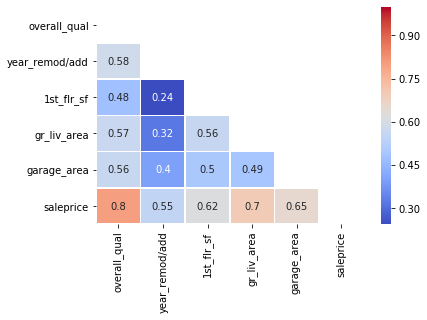

In [24]:
plt.figure(figsize=(6,4))                          ### Larger please
df_corr = df_train_cont_pear.corr()
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


ax = sns.heatmap(df_corr, cmap='coolwarm', linewidths=.5, annot=True, mask = mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### RFE

In [25]:
### Explain the RFE procedure. In Markdown.

X = df_train_cont_pear.drop('saleprice', axis = 1)
y = df_train_cont_pear['saleprice']

In [26]:
#no of features
nof_list=np.arange(1,6)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 89)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 5
Score with 5 features: 0.791238


In [27]:
lm = LinearRegression()
rfe = RFE(lm, 4)
selector = rfe.fit(X, y)
selector.support_

array([ True,  True, False,  True,  True])

In [28]:
selector.ranking_

array([1, 1, 2, 1, 1])

In [29]:
X_rfe_cols = X.columns[selector.support_]
X_rfe_cols

Index(['overall_qual', 'year_remod/add', 'gr_liv_area', 'garage_area'], dtype='object')

In [30]:
df_train_cont_pear_rfe = X[X_rfe_cols]

### Concat Cont and Cat Features

In [31]:
df_train_dum = pd.concat([df_train_cont_pear_rfe, df_train_cat], axis = 1)

## Train Test Split

In [32]:
X = df_train_dum
y = df_train.saleprice

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 88)

## Standard Scaler

In [34]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [35]:
X_train_ss = pd.DataFrame(X_train_ss, columns = X_train.columns)

In [36]:
X_test_ss = pd.DataFrame(X_test_ss, columns = X_test.columns)

## Feature Selecton

In [37]:
# X = df_train_dum
# y = df_train.saleprice

### - Lasso

In [38]:
def Lasso_func(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import Lasso, LassoCV
    
    las_cv = LassoCV(n_alphas = 1000, cv = 10)
    model_las_cv = las_cv.fit(X_train, y_train)
    print(f"\nThe optimal Lasso alpha value is: {model_las_cv.alpha_}")
    
    las_opt_alpha = model_las_cv.alpha_
    las_opt_model = Lasso(alpha=las_opt_alpha)
    las_opt_model.fit(X_train, y_train)
    print(f"\nThe Lasso model has a score of: {las_opt_model.score(X_train, y_train)}\n")
    
    col_coef = pd.DataFrame()
    col_coef['col_names'] = X_train.columns
    abs(las_opt_model.coef_)
    col_coef['coef'] = abs(las_opt_model.coef_)
    print(col_coef.sort_values('coef', ascending=False))

    zero_coef = col_coef.loc[col_coef['coef'] == 0]
    print(list(zero_coef.col_names))
    
    return zero_coef.col_names


In [39]:
# Try to return zero_coef out of function
df_zero_coef = Lasso_func(X_train_ss, X_test_ss, y_train, y_test)


The optimal Lasso alpha value is: 288.3318675523569

The Lasso model has a score of: 0.9002564872787225

                col_names          coef
2             gr_liv_area  24760.713194
85      roof_matl_CompShg  22378.731419
87      roof_matl_Tar&Grv  15979.873272
171       kitchen_qual_TA  12778.909284
0            overall_qual  12384.137330
..                    ...           ...
111  exterior_2nd_MetalSd      0.000000
105  exterior_2nd_Brk Cmn      0.000000
103  exterior_1st_WdShing      0.000000
101  exterior_1st_VinylSd      0.000000
220         sale_type_WD       0.000000

[221 rows x 2 columns]
['ms_zoning_FV', 'ms_zoning_I (all)', 'ms_zoning_RH', 'ms_zoning_RL', 'alley_Pave', 'alley_none', 'utilities_NoSewr', 'lot_config_FR3', 'lot_config_Inside', 'neighborhood_BrkSide', 'neighborhood_CollgCr', 'neighborhood_Landmrk', 'neighborhood_Sawyer', 'condition_1_Feedr', 'condition_2_Feedr', 'condition_2_Norm', 'condition_2_RRAn', 'condition_2_RRNn', 'roof_style_Gable', 'exterior_1st_As

In [40]:
#X_train_ss_lasso = X_train_ss.drop(df_zero_coef, axis = 1)
#X_test_ss_lasso = X_test_ss.drop(df_zero_coef, axis = 1)

In [41]:
lcv = LassoCV()

In [42]:
cross_val_score(lcv, X_train_ss, y_train, cv = 10).mean()

C:\Users\Kelvyn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Kelvyn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Kelvyn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Kelvyn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING,

0.8155842006248456

In [43]:
X_train_ss = X_train_ss.drop(df_zero_coef, axis = 1)
X_test_ss = X_test_ss.drop(df_zero_coef, axis = 1)

### Gridsearch

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LassoCV

In [45]:
lasso_parameters = {'alpha' : np.linspace(0.1, 10, 100)}  ### you don't need to pass the values like this 
lasso = Lasso()

In [46]:
lasso_gridsearchCV = GridSearchCV(lasso,
                              lasso_parameters,
                              cv=5,
                              verbose=1,
                              n_jobs=-1)

In [47]:
lasso_gridsearchCV.fit(X_train_ss, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 449 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 485 out of 500 | elapsed:   16.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,...
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1, 

In [48]:
gs_y_hat = lasso_gridsearchCV.predict(X_test_ss) ### I should see a y_pred against y_test 

In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt                            ### You don't have to sqrt using a function!
rms = sqrt(mean_squared_error(y_test, gs_y_hat)) ### just x ** 0.5 would have worked.
rms

25893.925956679155

### EDA

In [50]:
#df_train_new = pd.concat([X_ss_dum_new, y], axis = 1)

In [51]:
#plt.figure(figsize=(16,12))
#plt.title('Insert Title.\n', weight='bold', fontsize = 25)
#df_corr = df_train_new.corr()
#mask = np.zeros_like(df_corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True


#ax = sns.heatmap(df_corr, cmap='coolwarm', linewidths=.5, annot=True, mask = mask)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)

In [52]:
#df_test.columns = map(str.lower, df_test.columns)
#df_test.columns = [i.replace(" ","_") for i in list(df_test.columns)]

In [53]:
#df_test = df_test.drop(['id', 'pid', 'alley', 'pool_qc', 'fence', 'misc_feature'], axis = 1)

In [54]:
#df_test = df_test.dropna()

In [55]:
#df_test_new = df_test[['overall_qual', 'year_built', 'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1',
         #'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area', 'full_bath', 'totrms_abvgrd',
         #'garage_yr_blt', 'garage_cars', 'garage_area']]

## Preparing Test Dataframe

In [56]:
df_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [57]:
df_test.shape

(879, 80)

### Formating column heads to be lowercase and no whitespaces

In [58]:
df_test.columns = map(str.lower, df_test.columns)

In [59]:
df_test.columns = [i.replace(" ","_") for i in list(df_test.columns)]

### Drop irrelevant features

In [60]:
df_test = df_test.drop(['id', 'pid', 'misc_feature'], axis = 1)

### Fill NaN

Fill relevant cont null values with 0:
'lot_frontage', 'mas_vnr_area', 'garage_cars', 'garage_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf'

In [61]:
fill_con_cols = ['lot_frontage', 'mas_vnr_area', 'garage_cars', 'garage_area', 'bsmtfin_sf_1',
                 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf']
df_test[fill_con_cols] = df_test[fill_con_cols].fillna(0)

Fill relavant cat null values with none:
'garage_qual', 'garage_cond', 'garagetype', 'garagefinish', 'fireplacequ', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'alley', 'fence', 'pool_qc', 'mas_vnr_type'

In [62]:
fill_cat_cols = ['garage_qual', 'garage_cond', 'garage_type', 'garage_finish', 'fireplace_qu',
                 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2',
                 'alley', 'fence', 'pool_qc', 'mas_vnr_type', 'electrical']
df_test[fill_cat_cols] = df_test[fill_cat_cols].fillna('none')

### Drop NaN

Drop remaining null values:
'garageyrblt', 'mas_vnr_type', 'bsmt_full_bath', 'bsmt_half_bath'

In [63]:
df_test = df_test.drop(['garage_yr_blt', 'mas_vnr_type', 'bsmt_full_bath', 'bsmt_half_bath'], axis = 1)

In [64]:
df_test.shape

(879, 73)

In [65]:
pd.set_option('display.max_rows', 500)
df_test.isna().sum().sum()

0

## Dummying categorical columns

In [66]:
#ms_zoning = pd.get_dummies(df_train.ms_zoning)
#street = pd.get_dummies(df_train.street)

In [ ]:
### You could have just concaternated the two datasets to each other, performed the 
### pd.get_dummies operation then split them up once you're done.
### since you're forcing drop_first, this is doubly important.
###
### (all categories)  init_col  |                         is_b  | is_c |
###                      a      |                          0    |  0   |
###                      b      |     -- get_dummies-->    1    |  0   |
###                      c      |                          0    |  1   |
###                      a      |                          0    |  0   |
###
### (missing one)     init_col  |                         is_c  |                           is_b  | is_c |
###                      b      |                          0    |                            0    |  0   |
###                      b      |     -- get_dummies-->    0    |    ---adding missing -->   0    |  0   |  which is wrong
###                      c      |                          1    |                            0    |  1   |
###                      c      |                          1    |                            0    |  1   |
###
### eg if your columns are (a, b ,c) for categories in train, you'd get is_b and is_c for columns in the get_dummies
### if you force drop_fist. But if you only have (b ,c) for categories in test, you'd get is_c for the column in the 
### dummied set, then adding back is_b would be wrong as it would suggest that there are no bs.

In [67]:
def dummy_conv(data):
    names=data.select_dtypes(exclude=['number']).columns
    return pd.get_dummies(data[names], drop_first=True)

In [68]:
df_test_dum = pd.get_dummies(df_test, drop_first=True)

In [69]:
df_test_dum.shape

(879, 234)

### Removing 0 coef features

In [75]:
### Could just perform a filtering here instead of manually typing out the variable names
### 
col_diff = ['condition_2_RRAe', 'pool_qc_Fa', 'bsmt_cond_Po', 'functional_Sal', 'heating_OthW', 'roof_matl_CompShg', 'neighborhood_GrnHill', 'bsmt_cond_Fa', 'utilities_NoSeWa', 'exterior_2nd_Stone', 'functional_Sev', 'ms_zoning_C (all)', 'garage_qual_Fa', 'roof_matl_Membran', 'pool_qc_Gd']
X_test_ss_new = X_test_ss.drop(col_diff, axis = 1)
X_train_ss_new = X_train_ss.drop(col_diff, axis = 1)

In [76]:
df_test_new = df_test_dum[X_test_ss_new.columns]

In [77]:
df_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Columns: 137 entries, overall_qual to sale_type_Oth
dtypes: int64(4), uint8(133)
memory usage: 141.8 KB


In [78]:
X_test_ss_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Columns: 137 entries, overall_qual to sale_type_Oth
dtypes: float64(137)
memory usage: 659.4 KB


## Standard Scaler

In [79]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df_test_ss = ss.fit_transform(df_test_new)

In [80]:
df_test_ss = pd.DataFrame(df_test_ss, columns = df_test_new.columns)

### RFE

In [81]:
lm = LinearRegression()
rfe = RFE(lm, 10)            ### Some justification necessary as to why only 10 were selected.
selector = rfe.fit(X_train_ss_new, y_train)
selector.support_

array([ True, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [82]:
selector.ranking_

array([  1,   7,   1,   1, 123, 117,  98,  13,  99,  29,  63,  30,  35,
        97,  34,  33,  93,  67,  45,  18,  21,  65, 128,  41,  95, 126,
       109,  69, 102,   5,   4,  20, 125, 118,  25,   8,  87,  47,  37,
        39,  40,  96,  66, 124, 121, 127,  60,  83,  54,  17,   9, 107,
         3, 111, 106,  56,  90,  57, 122,  52,  48, 110, 120,  70,  28,
        11,  31,  81,  24,  44, 115,  26, 104,  32,  53, 100,  75,  94,
        19,  15,  14,  88, 114,  78,  64,  91,   1,   1,   1,   1, 112,
        16,   2,  59,  58,  73,  50,  68,  42,  49,  10,  22,  85,  76,
        38,  36,  74,  89,   1,   1,   1, 108,  46,  23,  82,  72,  61,
         6,  51,  86,  55, 101, 116,  43,  79,  84,  71,  92,  62, 113,
       103,  77,  27, 105, 119,  12,  80])

In [83]:
final_rfe = X_train_ss_new.columns[selector.support_]

In [84]:
final_x_train_rfe = X_train_ss_new[final_rfe]
final_df_test_rfe = df_test_ss[final_rfe]

In [96]:
final_df_test_rfe.columns

Index(['overall_qual', 'gr_liv_area', 'garage_area', 'bsmt_qual_Fa',
       'bsmt_qual_Gd', 'bsmt_qual_TA', 'bsmt_qual_none', 'kitchen_qual_Fa',
       'kitchen_qual_Gd', 'kitchen_qual_TA'],
      dtype='object')

### Retraining the model with new features

In [86]:
lm = LinearRegression()

In [87]:
lm.fit(final_x_train_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [88]:
lm_yhat = lm.predict(final_df_test_rfe)

In [89]:
lm_yhat

array([167050.91151368, 182201.16230218, 200780.02562918, 120931.32607221,
       171075.46283715,  98586.70423717,  99875.8234857 , 148370.24306331,
       217640.30423409, 150023.44212155, 175914.37967063, 131379.36381531,
       152780.28650437, 304477.1145357 , 159669.86336318, 116337.78423549,
       176700.69733091, 117372.92471408, 167510.13825761, 213513.88654605,
       126784.42479165, 130881.88056494, 195377.08422839, 141684.47645379,
       197689.43376042, 109335.73749044, 130181.41867665, 187465.50988154,
       154958.14655293,  48098.79407211, 111393.08821531, 117770.37146618,
       259401.59053981, 155219.22659657, 210932.65029325, 200782.61949118,
       114969.88627561,  97349.4039416 , 128692.6342186 , 206307.28734754,
       178701.17299405, 217330.80396769, 157993.18580438, 126520.68506425,
       205864.81283555,  92881.55980325, 223195.67408312, 110600.12540426,
       109844.11042348, 114182.05081173, 114466.27586449, 238774.76158962,
       247095.30389413, 1

### Creating CSV for Submission

In [90]:
df_test_2 = pd.read_csv('./datasets/test.csv')

In [91]:
results = pd.DataFrame(df_test_2.Id)

In [92]:
#results = pd.DataFrame()

In [93]:
results['SalePrice'] = lm_yhat

In [94]:
results.to_csv('./datasets/p2_results.csv', index=False)